In [1]:
from keras.models import Model
from keras.layers import Input, Conv2D
from keras.layers import Conv2DTranspose, LeakyReLU
from keras.layers.core import Activation
from keras.optimizers import Adam
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import cifar10, fashion_mnist

def data_choice(x, label):
    normal, anomaly = [], []
    for i in range(len(x)):
        if label[i] == 3:# cat
            normal.append(x[i])
        elif label[i] == 5:# dog
            anomaly.append(x[i])

    return np.array(normal), np.array(anomaly)

def get_data():
    # dataset
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()
    #(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

    #x_train = np.expand_dims(x_train, axis=-1)
    #x_test = np.expand_dims(x_test, axis=-1)

    x_train = x_train.astype('float32') / 255
    x_test = x_test.astype('float32') / 255

    x_train_normal, _ = data_choice(x_train, y_train)
    x_test_normal, x_test_anomaly = data_choice(x_test, y_test)

    return x_train_normal, x_test_normal, x_test_anomaly

def plot_fig(fig1, fig2, fig3, anomaly_detection=False):
    plt.figure(figsize=(11,45))
    plt.subplot(1,3,1)
    plt.imshow(fig1)
    if anomaly_detection:
        plt.title("Original data")
    else:
        plt.title("Train normal data")

    plt.subplot(1,3,2)
    plt.imshow(fig2)
    if anomaly_detection:
        plt.title("Reconstruction data")
    else:
        plt.title("Test normal data")

    plt.subplot(1,3,3)
    if anomaly_detection:
        plt.imshow(np.sum(np.abs(fig3), axis=-1), cmap="gray")
        plt.title("difference data(score=%d)" % np.sum(np.abs(fig3)))
    else:
        plt.imshow(fig3)
        plt.title("Test anomaly data")
    plt.show()

In [2]:
x_train_normal, x_test_normal, x_test_anomaly = get_data()

170500096/170498071 [==============================] - 16s 0us/step


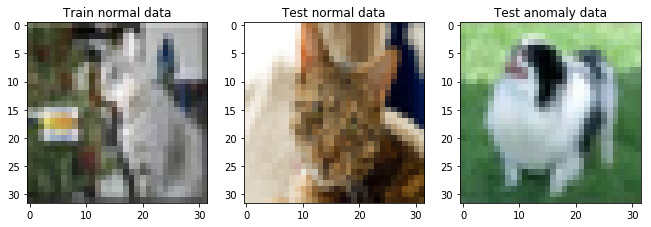

In [3]:
plot_fig(x_train_normal[10], x_test_normal[10], x_test_anomaly[10])

In [4]:
def build_model(x, channel=3):
    # build encoder
    inputs = Input(x.shape[1:])
    x = Conv2D(32, (5, 5), padding='same', strides=(2,2))(inputs)
    x = Activation('relu')(x)#16*16
  
    x = Conv2D(64, (5, 5), padding='same', strides=(2,2))(x)
    x = Activation('relu')(x)#8*8

    # build decoder
    x = Conv2DTranspose(32, (5, 5), padding='same', strides=(2,2))(x)
    x = Activation('relu')(x)#16*16
  
    x = Conv2DTranspose(channel, (5, 5), padding='same', strides=(2,2))(x)
    x = Activation('sigmoid')(x)#32*32
  
    # build ae
    ae =  Model(inputs, x)
    
    return ae

In [5]:
model = build_model(x_train_normal)
model.summary()

W0108 14:06:15.802352 140607530112832 deprecation_wrapper.py:119] From /home/ryamaguchi/wark/wark/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0108 14:06:15.825038 140607530112832 deprecation_wrapper.py:119] From /home/ryamaguchi/wark/wark/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0108 14:06:15.830781 140607530112832 deprecation_wrapper.py:119] From /home/ryamaguchi/wark/wark/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 32)        2432      
_________________________________________________________________
activation_1 (Activation)    (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 64)          51264     
_________________________________________________________________
activation_2 (Activation)    (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 16, 16, 32)        51232     
_________________________________________________________________
activation_3 (Activation)    (None, 16, 16, 32)        0         
__________

In [6]:
model.compile(optimizer=Adam(lr=0.0002, beta_1=0.5), loss="mse")

hist = model.fit(x_train_normal, x_train_normal,
                 validation_data=(x_test_normal, x_test_normal),
                 epochs=100,
                 verbose=True,
                 batch_size=128)


W0108 14:07:17.461564 140607530112832 deprecation_wrapper.py:119] From /home/ryamaguchi/wark/wark/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0108 14:07:17.587182 140607530112832 deprecation_wrapper.py:119] From /home/ryamaguchi/wark/wark/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0108 14:07:17.678166 140607530112832 deprecation_wrapper.py:119] From /home/ryamaguchi/wark/wark/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Train on 5000 samples, validate on 1000 samples
Epoch 1/100
5000/5000 [==============================] - 3s 562us/step - loss: 0.0633 - val_loss: 0.0579
Epoch 2/100
5000/5000 [==============================] - 2s 458us/step - loss: 0.0389 - val_loss: 0.0350
Epoch 3/100
5000/5000 [==============================] - 2s 471us/step - loss: 0.0270 - val_loss: 0.0348
Epoch 4/100
5000/5000 [==============================] - 2s 487us/step - loss: 0.0220 - val_loss: 0.0216
Epoch 5/100
5000/5000 [==============================] - 2s 464us/step - loss: 0.0194 - val_loss: 0.0228
Epoch 6/100
5000/5000 [==============================] - 2s 463us/step - loss: 0.0176 - val_loss: 0.0172
Epoch 7/100
5000/5000 [==============================] - 2s 485us/step - loss: 0.0164 - val_loss: 0.0146
Epoch 8/100
5000/5000 [==============================] - 3s 642us/step - loss: 0.0150 - val_loss: 0.0144
Epoch 9/100
5000/5000 [==============================] - 3s 651us/step - loss: 0.0139 - val_loss: 0.0128
Epoch 1

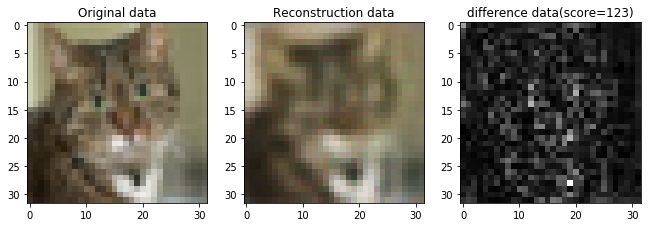

In [7]:
test = x_test_normal[33]
predict = model.predict(np.expand_dims(test, axis=0))

plot_fig(test, predict[0], test - predict[0], True)

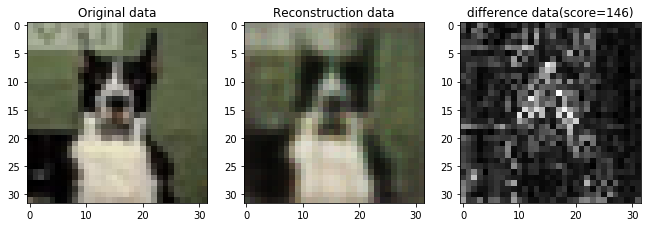

In [8]:
test = x_test_anomaly[33]
predict = model.predict(np.expand_dims(test, axis=0))

plot_fig(test, predict[0], test - predict[0], True)

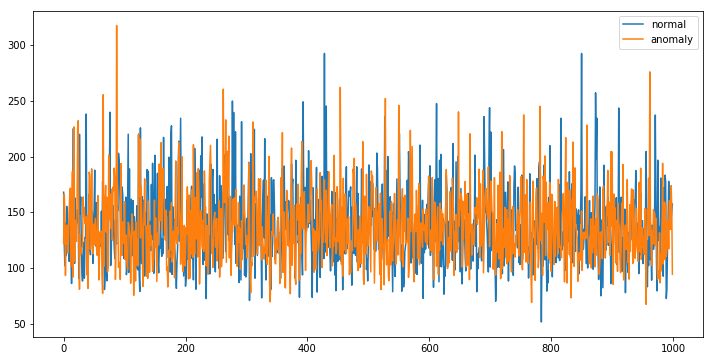

In [9]:
normal_score = np.abs(model.predict(x_test_normal) - x_test_normal)
normal_score = np.sum(normal_score.reshape(len(normal_score),-1),axis=1)
anomaly_score = np.abs(model.predict(x_test_anomaly) - x_test_anomaly)
anomaly_score = np.sum(anomaly_score.reshape(len(anomaly_score),-1),axis=1)

plt.figure(figsize=(12,6))
plt.plot(normal_score, label="normal")
plt.plot(anomaly_score, label="anomaly")
plt.legend()
plt.show()

In [10]:
from sklearn import metrics

def get_auc(test_normal, test_anomaly):
    #ROC曲線の描画
    y_true = np.zeros(len(test_normal)+len(test_anomaly))
    y_true[len(test_normal):] = 1#0:正常、1：異常

    # FPR, TPR(, しきい値) を算出
    fpr, tpr, _ = metrics.roc_curve(y_true, np.hstack((test_normal, test_anomaly)))

    # AUC
    auc = metrics.auc(fpr, tpr)
    
    # ROC曲線をプロット
    plt.plot(fpr, tpr, label='AUC = %.2f'%auc)
    plt.legend()
    plt.title('ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid(True)
    plt.show()

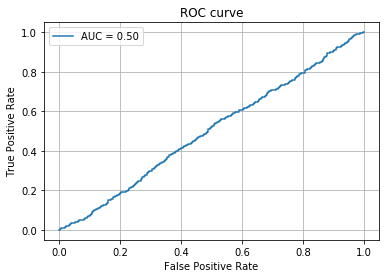

In [11]:
get_auc(normal_score, anomaly_score)